<a href="https://colab.research.google.com/github/nickolaychekotko/ML-DS/blob/main/PulseModeration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
from google.colab import drive
from pathlib import Path
import numpy as np
import pandas as pd

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
data_path = Path('/content/drive/MyDrive/pulse_moderation')

In [ ]:
df = pd.read_csv(data_path / "data.csv")

In [ ]:
_df = pd.DataFrame()
with open(data_path / "begging_aug.txt", "r") as f:
    _df["post_txt"] = list(filter(lambda s: len(s.strip()) > 0, f))
    _df["is_manipulation"] = np.zeros(len(_df["post_txt"]))
    _df["is_profanity"] = np.zeros(len(_df["post_txt"]))
    _df["is_advertisement"] = np.zeros(len(_df["post_txt"]))
    _df["is_begging"] = np.ones(len(_df["post_txt"]))
df = pd.concat([df, _df])

In [ ]:
_df = pd.DataFrame()
with open(data_path / "advertisiment_aug.txt", "r") as f:
    _df["post_txt"] = list(f)
    _df["is_manipulation"] = np.zeros(len(_df["post_txt"]))
    _df["is_profanity"] = np.zeros(len(_df["post_txt"]))
    _df["is_advertisement"] = np.ones(len(_df["post_txt"]))
    _df["is_begging"] = np.zeros(len(_df["post_txt"]))
df = pd.concat([df, _df])

# Features

In [ ]:
def get_label(c1, c2, c3, c4, ret_index=False):
    if c1:
        return "manipulation" if not ret_index else 0
    if c2:
        return "profanity" if not ret_index else 1
    if c3:
        return "advertisement" if not ret_index else 2
    if c4:
        return "begging" if not ret_index else 3
    return "normal" if not ret_index else 4

In [ ]:
from collections import Counter


def create_counter(df):
    tokenizer = RegexpTokenizer(r'\w+')
    texts = []
    for line in df.post_txt:
        texts += [w for w in tokenizer.tokenize(line.lower()) if w not in stop_words]
    return Counter(texts)

In [ ]:
from sklearn.metrics import f1_score


def f1(y_true, y_pred):
    assert False, f"{y_true} {y_pred}"
    return np.mean([f1_score(y_train.numpy()[:, i], (y_pred.numpy() > .5)[:, i]) for i in range(5)])

# Data analysis

In [ ]:
df.head(10)

,post_txt,is_manipulation,is_profanity,is_advertisement,is_begging
0,{$NGG3} невдумацте покупать и шортить,1,0,0,0
1,{$NGF3} Вспомнил анекдот про лонги...\nВесь пи...,0,1,0,0
2,"{$POSI} #идея_на_миллион Покупаем , ждём рост ...",1,0,0,0
3,{$UWGN} биржа начинает подниматься ! Кто не ус...,1,0,0,0
4,"??ПОКА ВЫ ПАНИКУЕТЕ, МЫ ЗАРАБАТЫВАЕМ?????\n\n?...",0,0,1,0
5,{$FLOT}\nЭкстренно \nДивиденды могут отменить....,1,0,0,0
6,{$KZOS} может организуем какую - то сексту и в...,1,0,0,0
7,"{$KZOSP} держимся до 40, не сливаем",1,0,0,0
8,{$TSLA} Аналитики прогнозируют 220-250$ к конц...,0,1,0,0
9,{$UNKL} не продаем! держим строй!,1,0,0,0


In [ ]:
from collections import Counter

counter = Counter()
for line in df.post_txt:
    counter.update(Counter(line))
counter.most_common(10)

[(' ', 523534),
 ('о', 276515),
 ('а', 218377),
 ('е', 217844),
 ('и', 209364),
 ('т', 182800),
 ('н', 169564),
 ('с', 135388),
 ('р', 133925),
 ('в', 110941)]

# GPT Generation

In [ ]:
!pip install transformers

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config
import torch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model_name_or_path = "sberbank-ai/rugpt3large_based_on_gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name_or_path)
model = GPT2LMHeadModel.from_pretrained(model_name_or_path).to(DEVICE)

# Fasttext classification (very bad)

In [ ]:
!git clone https://github.com/facebookresearch/fastText.git
%cd fastText
!sudo pip install .
%cd ..

Cloning into 'fastText'...
remote: Enumerating objects: 3938, done.
remote: Counting objects: 100% (1011/1011), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 3938 (delta 915), reused 868 (delta 863), pack-reused 2927
Receiving objects: 100% (3938/3938), 8.25 MiB | 14.84 MiB/s, done.
Resolving deltas: 100% (2509/2509), done.
/content/fastText
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/fastText
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4384288 sha256=414f245f7fd50cbe6ada811ba1d9e645c562f837aff72a61462c8208ad231283
  Stored in directory: /tmp/pip-ephem-wheel-cache-kns9d5yk/wheels/8b/05/af/3cfae069d904597d44b309c956601b611bdf8967bcbe968903
Successfully built fasttext
/content


In [ ]:
import fasttext.util

In [ ]:
fasttext.util.download_model('ru', if_exists='ignore')

In [ ]:
ft = fasttext.load_model('cc.ru.300.bin')

In [ ]:
!cp /content/cc.ru.300.bin.gz {data_path}

In [ ]:
ft.get_nearest_neighbors("ИТкомпании")

[(0.5832644701004028, 'компании9ffABTAC'),
 (0.5769837498664856, 'биржеКомпании'),
 (0.5520970225334167, 'продавцыКомпании'),
 (0.545464277267456, 'Техкомпании'),
 (0.5289483070373535, 'вкомпании'),
 (0.5282614827156067, 'Энергокомпании'),
 (0.5269455909729004, 'бизнес-компании'),
 (0.5099751949310303, 'компании.www.Avto-Olimp.ru'),
 (0.5071448087692261, 'компании808'),
 (0.5030081868171692, 'компании-интегратора')]

In [ ]:
lines = []
for line, c1, c2, c3, c4 in df.itertuples(index=False, name=None):
    _line = ""
    for w in line.split():
        if w.startswith("{$") and w.endswith("}"):
            pass
        else:
            _line += "".join(filter(lambda x: x.isalpha(), w)) + ' '
    lines.append((_line.strip(), get_label(c1, c2, c3, c4)))

In [ ]:
with open("lines.txt", "w", encoding='utf-8') as f:
    for line, label in lines:
        f.write("__label__" + label + " " + line +  "\n")

In [ ]:
!head lines.txt

__label__manipulation невдумацте покупать и шортить
__label__profanity Вспомнил анекдот про лонги Весь писать долго Заканчивается так Нихя дохя нахярили Расхяривай нахй
__label__manipulation идеянамиллион Покупаем  ждём рост дивидендов
__label__manipulation биржа начинает подниматься  Кто не успел закупить  больше шансов по этой цене не будет
__label__advertisement ПОКА ВЫ ПАНИКУЕТЕ МЫ ЗАРАБАТЫВАЕМ КОГДА ЛИКВИДНЫЕ АКЦИИ ПАДАЮТ ТО ЛОГИЧНО ИХ ПРИОБРЕТАТЬ ЧТО МЫ И СДЕЛАЛИ КОГДА ИЗ КАЖДОГО УТЮГА КРИЧАЛИ БУДЕТ КРАХ ОБВАЛ БИРЖИ МЫ ПОЛЬЗОВАЛИСЬ ХОРОШИМИ ЦЕНАМИ НА АКЦИИСБЕР РОСНЕФТЬ И ТД НА ЧЕМ СЕЙЧАС ПРЕКРАСНО ЗАРАБАТЫВАЕМ КТО ДАВНО ПОДПИСАН НА МЕНЯ ТОТ ЗНАЕТ ЧТО СО МНОЙ ЗАРАБАТЫВАЮТ учувпульсе проявисебявпульсе новичкам психология пульс сбербанк акции инвестиции трейдинг добычаденег
__label__manipulation Экстренно Дивиденды могут отменить Будьте аккуратней вышла новость её сразу же удалили Я если найду подтверждение то обязательно выложу Ситуация напряжённая 2021 повторяется
__label__manipul

In [ ]:
model = fasttext.train_supervised(input="lines.txt", wordNgrams=5, lr=1.0, epoch=25)

In [ ]:
model.predict("блять", k=4)

(('__label__normal',
  '__label__profanity',
  '__label__begging',
  '__label__advertisement'),
 array([1.00001001e+00, 1.00000034e-05, 1.00000034e-05, 1.00000034e-05]))

In [ ]:
model.test("lines.txt")

(24834, 0.824112104373037, 0.824112104373037)

In [ ]:
from nltk.tokenize.regexp import RegexpTokenizer

In [ ]:
lines = []
tokenizer = RegexpTokenizer(r"\w+")
for line, *_ in df.itertuples(index=False, name=None):
    lines.append(" ".join(tokenizer.tokenize(line.lower())))
lines[:5]

In [ ]:
with open("lines.txt", "w") as f:
    f.write("\n".join(lines))

In [ ]:
!head lines.txt -n 5

ngg3 невдумацте покупать и шортить
ngf3 вспомнил анекдот про лонги весь писать долго заканчивается так них я дох я нах ярили расх яривай нах й
posi идея_на_миллион покупаем ждём рост дивидендов
uwgn биржа начинает подниматься кто не успел закупить больше шансов по этой цене не будет
пока вы паникуете мы зарабатываем когда ликвидные акции падают то логично их приобретать что мы и сделали когда из каждого утюга кричали будет крах обвал биржи мы пользовались хорошими ценами на акции сбер роснефть и т д на чем сейчас прекрасно зарабатываем кто давно подписан на меня тот знает что со мной зарабатывают учу_в_пульсе прояви_себя_в_пульсе новичкам психология пульс сбербанк акции инвестиции трейдинг добычаденег sber rosn


In [ ]:
import fasttext

In [ ]:
model = fasttext.train_unsupervised("lines.txt", minn=2, maxn=5, dim=50, epoch=8, lr=.02)

In [ ]:
model.save_model(str(data_path / "custom_embedding.model"))

In [ ]:
import fasttext

In [ ]:
model = fasttext.load_model(str(data_path / "custom_embedding.model"))

In [ ]:
with open(data_path / "custom_embedding.vec", "w", encoding="utf-8") as f:
    f.write(f"{len(model.get_words())} {model.get_dimension()}\n")
    f.write("\n".join([w + " " + " ".join(map(str, model.get_word_vector(w))) for w in model.get_words()]))

# Custom Embedding RNN

## Imports

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import os, re, csv, math, codecs

from sklearn.model_selection import train_test_split
from keras.utils import pad_sequences
from keras.layers import Bidirectional, LSTM, Embedding
import pickle

In [ ]:
#training params
batch_size = 256
num_epochs = 8

#model parameters
num_filters = 64
embed_dim = 300
weight_decay = 1e-4

In [ ]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
sns.set_style("whitegrid")
np.random.seed(0)

In [ ]:
MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('russian'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

In [ ]:
USE_TRAIN_TEST_SPLIT = False

In [ ]:
if USE_TRAIN_TEST_SPLIT:
    train_df, test_df = train_test_split(df, train_size=.8)
    print("num train: ", train_df.shape[0])
    print("num test: ", test_df.shape[0])
else:
    train_df = df

In [ ]:
label_names = ('normal', 'profanity', 'begging', 'advertisement', 'manipulation')

In [ ]:
y_train = []
for _, c1, c2, c3, c4, *_ in train_df.itertuples(index=False, name=None):
    y_train.append([c1, c2, c3, c4, int(not (c1 or c2 or c3 or c4))])

In [ ]:
train_df['doc_len'] = train_df['post_txt'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.max(train_df['doc_len']).astype(int)

In [ ]:
raw_docs_train = train_df['post_txt'].tolist()
if USE_TRAIN_TEST_SPLIT:
    raw_docs_test = test_df['post_txt'].tolist()
num_classes = len(label_names)

In [ ]:
processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = tokenizer.tokenize(doc.lower())
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))

if USE_TRAIN_TEST_SPLIT:
    processed_docs_test = []
    for doc in tqdm(raw_docs_test):
        tokens = tokenizer.tokenize(doc.lower())
        filtered = [word for word in tokens if word not in stop_words]
        processed_docs_test.append(" ".join(filtered))

100%|██████████| 4967/4967 [00:00<00:00, 57934.60it/s]


In [ ]:
def parse_line(line):
    res = []
    for w in line.split():
        res.append(emb_model.get_word_id(w))
        if res[-1] == -1:
            res.pop()
    return res

In [ ]:
print(*[parse_line(line) for line in processed_docs_train][:10], sep="\n")

[1052, 502, 904, 12845, 1387, 59]
[394, 4072, 2150, 7370, 6544, 344]
[537, 1960, 1875, 426, 3613, 4648, 208, 669, 583]
[5107, 10369, 819, 774, 209, 6351, 7386, 1682, 879, 283]
[1149, 5778, 2136, 987, 3790, 283, 661]
[469, 1620, 445, 1562, 34, 4287]
[1753, 2805, 3126, 133, 197, 197]
[2717, 5410, 10521, 1191, 4151, 1782]
[8691, 956, 420, 2171]
[1149, 6037, 358, 228, 590, 12972, 536, 3956, 478, 4478, 274, 3551, 1505, 1792]


In [ ]:
word_tokens_train = pad_sequences([parse_line(line) for line in processed_docs_train], maxlen=max_seq_len)
if USE_TRAIN_TEST_SPLIT:
    word_tokens_test = pad_sequences([parse_line(line) for line in processed_docs_test], maxlen=max_seq_len)

In [ ]:
np.array(word_tokens_train).shape

(19867, 1383)

In [ ]:
model = Sequential()
model.add(Embedding(len(emb_model.get_words()), emb_model.get_dimension(),
          weights=[emb_model.get_output_matrix()], input_length=max_seq_len, trainable=False))
model.add(Bidirectional(LSTM(50)))
model.add(Dense(num_classes, activation='sigmoid'))

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 1383, 50)          656400    
                                                                 
 bidirectional_6 (Bidirectio  (None, 100)              40400     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 5)                 505       
                                                                 
Total params: 697,305
Trainable params: 40,905
Non-trainable params: 656,400
_________________________________________________________________


In [ ]:
hist = model.fit(
    word_tokens_train,
    np.array(y_train),
    batch_size=batch_size,
    epochs=num_epochs,
    shuffle=True,
    validation_split=.25,
    verbose=2
)

Epoch 1/8
59/59 - 356s - loss: 0.3654 - accuracy: 0.6515 - val_loss: 0.2656 - val_accuracy: 0.6797 - 356s/epoch - 6s/step
Epoch 2/8
59/59 - 342s - loss: 0.2407 - accuracy: 0.7346 - val_loss: 0.2296 - val_accuracy: 0.7582 - 342s/epoch - 6s/step
Epoch 3/8


KeyboardInterrupt: ignored

# CNN and RNN

## Imports

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import os, re, csv, math, codecs

from sklearn.model_selection import train_test_split
from keras.utils import pad_sequences
from keras.layers import Bidirectional, LSTM, Embedding
import pickle

In [ ]:
#training params
batch_size = 256
num_epochs = 8

#model parameters
num_filters = 64
embed_dim = 300
weight_decay = 1e-4

In [ ]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
sns.set_style("whitegrid")
np.random.seed(0)

In [ ]:
MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('russian'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])
# EMBEDDING_PATH = data_path / "custom_embedding.vec"
EMBEDDING_PATH = data_path / "cc.ru.300.vec"
FREQ_FILTER = -1

In [ ]:
label_names = ('manipulation', 'profanity', 'advertisement', 'begging', 'normal')

## Freq Analyze

In [ ]:
from collections import Counter

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')
texts = []
for line in df.post_txt:
    texts += [w for w in tokenizer.tokenize(line.lower()) if w not in stop_words]
arr = np.fromiter(map(lambda x: x[1], Counter(texts).most_common()), dtype=int)
counter = Counter(texts)

In [ ]:
arr.shape[0] * .2

11242.2

In [ ]:
np.quantile(arr, .8)

5.0

## Download fasttext vectors

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz

--2023-05-02 07:17:17--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 65.8.248.107, 65.8.248.127, 65.8.248.124, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|65.8.248.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1306357571 (1.2G) [binary/octet-stream]
Saving to: ‘cc.ru.300.vec.gz’

cc.ru.300.vec.gz     18%[==>                 ] 224.48M  65.6MB/s    eta 16s    ^C


In [ ]:
!gunzip cc.ru.300.vec.gz

In [ ]:
!cp /content/cc.ru.300.vec {data_path}

cp: cannot stat '/content/cc.ru.300.vec': No such file or directory


## Load embeddings

In [ ]:
embeddings_index = {}
f = codecs.open(EMBEDDING_PATH, encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('\nfound %s word vectors' % len(embeddings_index))

2000001it [03:48, 8734.20it/s] 


found 2000000 word vectors


## Get Class Weights

In [ ]:
_df = df.copy()
_df["label"] = list(map(lambda x: get_label(x[1], x[2], x[3], x[4]), _df.itertuples(index=False, name=None)))
_weights = 1 - (_df.label.value_counts() / len(_df.label))
class_weights = {
    i: _weights[label_names[i]]
    for i in range(5)
}

## Prepare train/test data

In [ ]:
USE_TRAIN_TEST_SPLIT = False

In [ ]:
if USE_TRAIN_TEST_SPLIT:
    train_df, test_df = train_test_split(df, train_size=.8)
    print("num train: ", train_df.shape[0])
    print("num test: ", test_df.shape[0])
else:
    train_df = df

In [ ]:
y_train = []
for _, c1, c2, c3, c4, *_ in train_df.itertuples(index=False, name=None):
    y_train.append([c1, c2, c3, c4, int(not (c1 or c2 or c3 or c4))])

In [ ]:
train_df['doc_len'] = train_df['post_txt'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train_df['doc_len'].mean() + train_df['doc_len'].std()).astype(int)

In [ ]:
max_seq_len = 64

## Визуализация данных

<ipython-input-183-d2dab33378f9>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df['doc_len'], hist=True, kde=True, color='b', label='doc len')


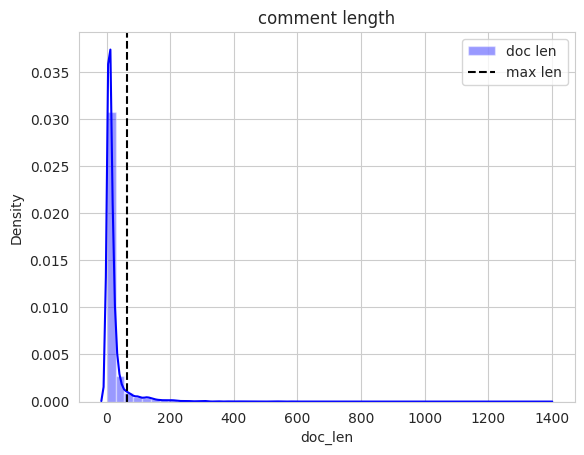

In [ ]:
sns.distplot(train_df['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('comment length'); plt.legend()
plt.show()

## Векторизация

In [ ]:
raw_docs_train = train_df['post_txt'].tolist()
if USE_TRAIN_TEST_SPLIT:
    raw_docs_test = test_df['post_txt'].tolist()
num_classes = len(label_names)

In [ ]:
counter = create_counter(df)

processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = tokenizer.tokenize(doc.lower())
    filtered = [word for word in tokens if (word not in stop_words) and (counter[word] >= FREQ_FILTER)]
    processed_docs_train.append(" ".join(filtered))

if USE_TRAIN_TEST_SPLIT:
    processed_docs_test = []
    for doc in tqdm(raw_docs_test):
        tokens = tokenizer.tokenize(doc.lower())
        filtered = [word for word in tokens if (word not in stop_words) and (counter[word] >= FREQ_FILTER)]
        processed_docs_test.append(" ".join(filtered))

100%|██████████| 27170/27170 [00:00<00:00, 55111.75it/s]


In [ ]:
with open(data_path / "0505_keras_tokenizer.pickle", "rb") as f:
    tokenizer = pickle.load(f)
# tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
if USE_TRAIN_TEST_SPLIT:
    tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)
    word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
else:
    tokenizer.fit_on_texts(processed_docs_train)

word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)

word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

dictionary size:  56398


In [ ]:
tokenizer.word_index["привет"]

192

In [ ]:
word_seq_train = pad_sequences(word_seq_train, maxlen=max_seq_len)
if USE_TRAIN_TEST_SPLIT:
    word_seq_test = pad_sequences(word_seq_test, maxlen=max_seq_len)

In [ ]:
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 10246


In [ ]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

sample words not found:  ['pompeufabra' 'wolf6wolf9' 'гуцериева' 'совбезом' 'докупайтесь' '40ee'
 '812248709621' 'лудоманом' 'закусайтесь' 'хакамада']


## VGG16 Learning

In [ ]:
model = Sequential()

model.add(Embedding(nb_words, embed_dim,
          weights=[embedding_matrix], input_length=max_seq_len, trainable=False))

model.add(Conv1D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(Conv1D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(MaxPooling1D(2))

model.add(Conv1D(filters=128, kernel_size=3, padding="same", activation="relu"))
model.add(Conv1D(filters=128, kernel_size=3, padding="same", activation="relu"))
model.add(MaxPooling1D(2))

model.add(Conv1D(filters=256, kernel_size=3, padding="same", activation="relu"))
model.add(Conv1D(filters=256, kernel_size=3, padding="same", activation="relu"))
model.add(Conv1D(filters=256, kernel_size=3, padding="same", activation="relu"))
model.add(MaxPooling1D(2))

model.add(Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(MaxPooling1D(2))

model.add(Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(MaxPooling1D(2))

model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))

model.add(Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(num_classes, activation='sigmoid'))  # multi-label (k-hot encoding)

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
# model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[f1])
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[keras.metrics.CategoricalAccuracy()])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 64, 50)            648600    
                                                                 
 conv1d_52 (Conv1D)          (None, 64, 64)            9664      
                                                                 
 conv1d_53 (Conv1D)          (None, 64, 64)            12352     
                                                                 
 max_pooling1d_20 (MaxPoolin  (None, 32, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_54 (Conv1D)          (None, 32, 128)           24704     
                                                                 
 conv1d_55 (Conv1D)          (None, 32, 128)           49280     
                                                      

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


## F1-score define

In [ ]:
from sklearn.metrics import f1_score
import keras.backend as K
from keras.metrics import Mean

m = Mean()

def _f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


def f1(y_true, y_pred):
    m.update_state([_f1(y_true[:, i], y_pred[:, i]) for i in range(5)])
    res = m.result()
    m.reset_state()
    return res

## Focal loss define

In [ ]:
import tensorflow as tf


def focal_loss(gamma=2., alpha=4.):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002
        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]
        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})
        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

## CNN Learning

In [ ]:
model = Sequential()
model.add(Embedding(nb_words, embed_dim,
          weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(num_classes, activation='softmax'))  # multi-label (k-hot encoding)

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
# model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[f1])
model.compile(optimizer=adam, loss=focal_loss(alpha=1), metrics="accuracy")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 64, 300)           16919700  
                                                                 
 conv1d_2 (Conv1D)           (None, 64, 64)            134464    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 32, 64)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 32, 64)            28736     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_1 (Dropout)         (None, 64)               

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
hist = model.fit(
    word_seq_train,
    np.array(y_train),
    batch_size=batch_size,
    epochs=10,
    shuffle=True,
    # validation_split=0.2,
    verbose=2,
    # class_weight=class_weights
)

Epoch 1/10
107/107 - 2s - loss: 0.5160 - accuracy: 0.6551 - 2s/epoch - 22ms/step
Epoch 2/10
107/107 - 1s - loss: 0.2611 - accuracy: 0.8126 - 774ms/epoch - 7ms/step
Epoch 3/10
107/107 - 1s - loss: 0.2025 - accuracy: 0.8523 - 681ms/epoch - 6ms/step
Epoch 4/10
107/107 - 1s - loss: 0.1701 - accuracy: 0.8736 - 673ms/epoch - 6ms/step
Epoch 5/10
107/107 - 1s - loss: 0.1482 - accuracy: 0.8874 - 674ms/epoch - 6ms/step
Epoch 6/10
107/107 - 1s - loss: 0.1289 - accuracy: 0.9025 - 689ms/epoch - 6ms/step
Epoch 7/10
107/107 - 1s - loss: 0.1140 - accuracy: 0.9121 - 670ms/epoch - 6ms/step
Epoch 8/10
107/107 - 1s - loss: 0.0985 - accuracy: 0.9256 - 689ms/epoch - 6ms/step
Epoch 9/10
107/107 - 1s - loss: 0.0849 - accuracy: 0.9363 - 661ms/epoch - 6ms/step
Epoch 10/10
107/107 - 1s - loss: 0.0732 - accuracy: 0.9454 - 674ms/epoch - 6ms/step


## RNN Learning

In [ ]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
    def precision(y_true, y_pred):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
model = Sequential()
model.add(Embedding(nb_words, embed_dim,
          weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(num_classes, activation='sigmoid'))

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
# model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[f1])
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=[f1])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 61, 300)           16919700  
                                                                 
 bidirectional_3 (Bidirectio  (None, 200)              320800    
 nal)                                                            
                                                                 
 dense_15 (Dense)            (None, 5)                 1005      
                                                                 
Total params: 17,241,505
Trainable params: 321,805
Non-trainable params: 16,919,700
_________________________________________________________________


In [ ]:
hist = model.fit(
    word_seq_train,
    np.array(y_train),
    batch_size=batch_size,
    epochs=15,
    shuffle=True,
    validation_split=0.2,
    verbose=2,
    class_weight=class_weights
)

Epoch 1/15
68/68 - 6s - loss: 0.6495 - f1: 0.3706 - val_loss: 0.7056 - val_f1: 0.4560 - 6s/epoch - 82ms/step
Epoch 2/15
68/68 - 1s - loss: 0.3998 - f1: 0.4873 - val_loss: 0.5908 - val_f1: 0.5021 - 1s/epoch - 17ms/step
Epoch 3/15
68/68 - 1s - loss: 0.3473 - f1: 0.5011 - val_loss: 0.5546 - val_f1: 0.4988 - 1s/epoch - 17ms/step
Epoch 4/15
68/68 - 1s - loss: 0.3172 - f1: 0.5041 - val_loss: 0.5317 - val_f1: 0.4931 - 1s/epoch - 16ms/step
Epoch 5/15
68/68 - 1s - loss: 0.3016 - f1: 0.5041 - val_loss: 0.5114 - val_f1: 0.5491 - 1s/epoch - 16ms/step
Epoch 6/15
68/68 - 1s - loss: 0.2837 - f1: 0.5082 - val_loss: 0.4878 - val_f1: 0.4878 - 1s/epoch - 16ms/step
Epoch 7/15
68/68 - 1s - loss: 0.2692 - f1: 0.5063 - val_loss: 0.4752 - val_f1: 0.4887 - 1s/epoch - 16ms/step
Epoch 8/15
68/68 - 1s - loss: 0.2568 - f1: 0.5097 - val_loss: 0.4479 - val_f1: 0.4896 - 1s/epoch - 16ms/step
Epoch 9/15
68/68 - 1s - loss: 0.2532 - f1: 0.5175 - val_loss: 0.4670 - val_f1: 0.5452 - 1s/epoch - 16ms/step
Epoch 10/15
68/68 -

## Test

In [ ]:
y_test = []
for _, c1, c2, c3, c4, *_ in test_df.itertuples(index=False, name=None):
    y_test.append([c1, c2, c3, c4, int(not (c1 or c2 or c3 or c4))])

In [ ]:
y_pred = model.predict(word_seq_test) > .5

170/170 [==============================] - 1s 4ms/step


In [ ]:
model.evaluate(word_seq_test, np.array(y_test))

170/170 [==============================] - 1s 5ms/step - loss: 0.4331 - f1: 0.4955


[0.43313443660736084, 0.49547079205513]

In [ ]:
y_test = np.array(y_test)

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
{
    label_names[i]: f1_score(y_test[:, i], y_pred[:, i])
    for i in range(5)
}

{'manipulation': 0.4514681892332789,
 'profanity': 0.2039877300613497,
 'advertisement': 0.4379297864639885,
 'begging': 0.7547169811320755,
 'normal': 0.8056310200049395}

In [ ]:
matr = np.array([[0] * 5 for _ in range(5)])
for yt, yp in zip(y_test, y_pred):
    yt = get_label(*yt[:-1], ret_index=True)
    matr[yt] += yp
matr

array([[ 866,    4,    9,    3,  166],
       [  12,   69,    1,    0,   35],
       [   8,    1,  474,    1,   81],
       [   4,    1,    5,  228,    5],
       [ 168,    2,   31,    1, 2895]])

In [ ]:
# CNN
model.evaluate(word_seq_test, np.array(y_test))

In [ ]:
# CNN CE FREQ >= 5
model.evaluate(word_seq_test, np.array(y_test))

156/156 [==============================] - 1s 6ms/step - loss: 0.1571 - f1: 0.8454


[0.15708670020103455, 0.8454002737998962]

In [ ]:
# RNN
model.evaluate(word_seq_test, np.array(y_test))

In [ ]:
# RNN CE
model.evaluate(word_seq_test, np.array(y_test))

156/156 [==============================] - 2s 15ms/step - loss: 0.1618 - f1: 0.8395


[0.16181430220603943, 0.8394867181777954]

## Result Visualization

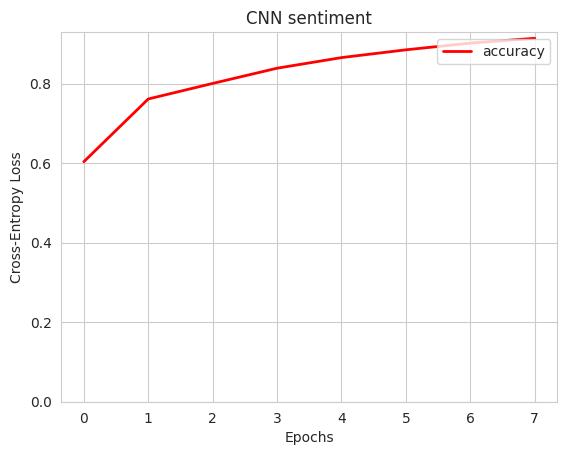

In [ ]:
# CNN
ax = plt.subplot()
plt.plot(hist.history['accuracy'], lw=2.0, color='r', label='accuracy')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')

ax.set_ylim(bottom=0)

plt.show()

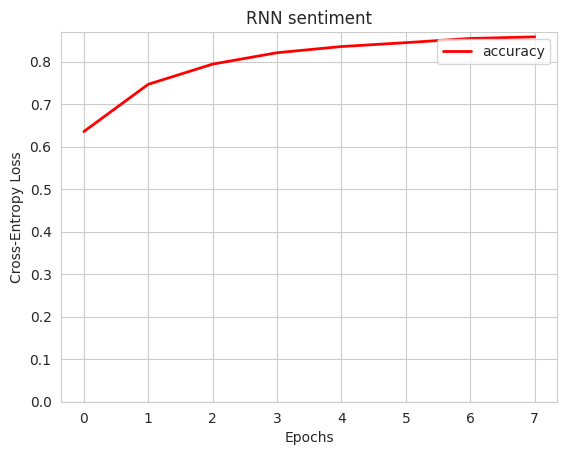

In [ ]:
# RNN
ax = plt.subplot()
plt.plot(hist.history['accuracy'], lw=2.0, color='r', label='accuracy')
plt.title('RNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')

ax.set_ylim(bottom=0)

plt.show()

## Model Save

In [ ]:
model.save(data_path / "focloss_pulse_model")

In [ ]:
model.save(data_path / "vgg16_pulse_model")

In [ ]:
model.save(data_path / "vgg16_ce_freq5_pulse_model")

In [ ]:
model.save(data_path / "rec_ce_freq5_pulse_model")

In [ ]:
model.save(data_path / "rec_pulse_model")

In [ ]:
with open(data_path / "0505_keras_tokenizer.pickle", "wb") as f:
    pickle.dump(tokenizer, f)

# Catboost + TF-idf

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score

In [ ]:
vectorizer = TfidfVectorizer(lowercase=True, tokenizer=None, preprocessor=None, min_df=5)
x = vectorizer.fit_transform(df.post_txt)

y_cols = ['is_manipulation', 'is_profanity', 'is_advertisement', 'is_begging']
y = df[y_cols]

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=42)

In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
classifier = CatBoostClassifier(loss_function='MultiLogloss')

In [ ]:
classifier.fit(
    train_x,
    train_y,
    eval_set=(test_x, test_y),
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.064153
0:	learn: 0.6124014	test: 0.6125757	best: 0.6125757 (0)	total: 2.29s	remaining: 38m 5s
1:	learn: 0.5455731	test: 0.5459253	best: 0.5459253 (1)	total: 3.41s	remaining: 28m 20s
2:	learn: 0.4899752	test: 0.4905884	best: 0.4905884 (2)	total: 4.27s	remaining: 23m 39s
3:	learn: 0.4465958	test: 0.4473963	best: 0.4473963 (3)	total: 5.08s	remaining: 21m 5s
4:	learn: 0.4113878	test: 0.4123277	best: 0.4123277 (4)	total: 5.86s	remaining: 19m 26s
5:	learn: 0.3818050	test: 0.3828927	best: 0.3828927 (5)	total: 6.66s	remaining: 18m 24s
6:	learn: 0.3569655	test: 0.3582438	best: 0.3582438 (6)	total: 7.46s	remaining: 17m 38s
7:	learn: 0.3351988	test: 0.3365881	best: 0.3365881 (7)	total: 8.48s	remaining: 17m 31s
8:	learn: 0.3169519	test: 0.3185112	best: 0.3185112 (8)	total: 9.93s	remaining: 18m 12s
9:	learn: 0.3017419	test: 0.3034485	best: 0.3034485 (9)	total: 11.4s	remaining: 18m 44s
10:	learn: 0.2898260	test: 0.2918089	best: 0.2918089 (10)	total: 12.7s	remaining: 18m 57s
11

# Model Interface

In [ ]:
from typing import Optional, List, Set, Tuple, Union, Dict
from keras.preprocessing.text import Tokenizer
from nltk.tokenize.regexp import RegexpTokenizer
from keras.utils import pad_sequences
from keras.engine.sequential import Sequential
import pickle
import nltk
from nltk.corpus import stopwords
from keras.models import load_model
from dataclasses import dataclass
import numpy as np


STOP_WORDS: Optional[Set[str]] = None
MAX_WORD_COUNT = 5
LABELS = ('manipulation', 'profanity', 'advertisement', 'begging', 'normal')


class ModelNotLoadException(Exception):
    def __init__(self):
        super().__init__("Model not load")


class TokenizerNotLoadException(Exception):
    def __init__(self):
        super().__init__("Tokenizer not load")


def init_stopwords_nltk():
    global STOP_WORDS

    nltk.download("stopwords")
    stop_words = set(stopwords.words('russian'))
    stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

    STOP_WORDS = stop_words


def preprocess_input(text: str, stop_words: Set[str]) -> List[str]:
    processed_docs = []
    tokens = RegexpTokenizer(r'\w+').tokenize(text)
    filtered = [word for word in tokens if word not in stop_words]
    return filtered


def vectorize_input(processed_docs: List[str], tokenizer: Tokenizer) -> List[List[int]]:
    return pad_sequences(tokenizer.texts_to_sequences(processed_docs), maxlen=64)


class PredictResult:
    separate_result: List[Tuple[str, np.array]]
    total_result: np.array
    text: str
    max_separates_len: int

    def __init__(self, separate_result):
        self.separate_result = separate_result
        self.total_result = self.calculate_total_result(separate_result)
        self.text = self.calculate_text(separate_result)
        self.max_separates_len = max(map(lambda x: len(x[0]), separate_result))

    @staticmethod
    def calculate_total_result(separate_result) -> np.array:
        funcs = (max, max, max, max, min)
        return np.array([funcs[i]([x[1][i] for x in separate_result]) for i in range(5)])

    @staticmethod
    def calculate_text(separate_result):
        return " ".join(map(lambda x: x[0], separate_result))

    def get_max_result(self):
        return np.max(self.total_result)

    def get_max_label(self):
        return LABELS[np.argmax(self.total_result)]

    def __repr__(self):
        return "<Prediction for \"{:.20}...\": {} with probability {:%}>".format(
            self.text,
            self.get_max_label(),
            self.get_max_result()
        )

    def __str__(self):
        return repr(self)

    def get_scores(self) -> Dict[str, List[Tuple[float, str]]]:
        return {LABELS[i]: [
            (proba[i], text)
            for text, proba in self.separate_result
            if np.argmax(proba) == i
        ] for i in range(len(LABELS))}

    def get_human_readable_separates(self) -> str:
        format_str = '{text:^{max_sep_len}} | {_class:^13} | {prob}'
        header = format_str.format(
            text="text",
            max_sep_len=self.max_separates_len,
            _class="class",
            prob="prob, %"
        )
        lines = [format_str.format(
            text=text,
            _class=LABELS[np.argmax(res)],
            prob=np.max(res) * 100,
            max_sep_len=self.max_separates_len
        ) for text, res in self.separate_result]
        return "\n".join([header] + lines)


class ClassifierModule:
    _model: Optional[Sequential] = None
    _tokenizer: Optional[Tokenizer]

    def __init__(self, path_to_model: Optional[str], path_to_tokenizer: Optional[str], init_stopwords=True):
        if path_to_model is not None:
            self.load_model(path_to_model)
        if path_to_tokenizer is not None:
            self.load_tokenizer(path_to_tokenizer)
        if init_stopwords:
            init_stopwords_nltk()

    def load_model(self, path_to_model: str, raise_exception: bool = False):
        try:
            self._model = load_model(path_to_model, compile=False)
        except Exception as e:
            self._model = None
            if raise_exception:
                raise e

    def get_model(self, raise_exception: bool = False):
        if self._model is None and raise_exception:
            raise ModelNotLoadException
        return self._model

    def load_tokenizer(self, path_to_tokenizer: str, raise_exception: bool = False):
        try:
            with open(path_to_tokenizer, "rb") as f:
                self._tokenizer = pickle.load(f)
        except Exception as e:
            self._tokenizer = None
            if raise_exception:
                raise e

    def get_tokenizer(self, raise_exception: bool = False):
        if self._tokenizer is None and raise_exception:
            raise TokenizerNotLoadException
        return self._tokenizer

    def _predict(self, data: List[str], verbose: int | str = 0):
        word_seq = vectorize_input(data, self.get_tokenizer(raise_exception=True))
        return self.get_model(raise_exception=True).predict(word_seq, verbose=verbose)

    def predict_one(self, text: str, max_words: Optional[int] = MAX_WORD_COUNT, verbose: int | str = 0):
        text = preprocess_input(text, STOP_WORDS)
        lines = []
        if max_words is not None:
            for i in range(max_words, len(text) + 1, max_words):
                lines.append(" ".join(text[i - max_words:i]))
            if len(text) % max_words > 0:
                lines.append(" ".join(text[-(len(text) % max_words):]))
        else:
            lines.append(" ".join(text))
        return PredictResult([(line, res) for line, res in zip(lines, self._predict(lines, verbose))])

    def predict_many(self, data: List[str], max_words: Optional[int] = MAX_WORD_COUNT, verbose: int | str = 0):
        return list(map(lambda x: self.predict_one(x, max_words, verbose), data))

In [ ]:
model = ClassifierModule(
    path_to_model=str(data_path / "focloss_pulse_model"),
    path_to_tokenizer=str(data_path / "0505_keras_tokenizer.pickle"),
    # init_stopwords=False
)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
model.load_model(str(data_path / "focloss_pulse_model"), raise_exception=True)

In [ ]:
model.predict_one("пошли шортить акции")

<Prediction for "пошли шортить акции...": manipulation with probability 75.992334%>

In [ ]:
print(model.predict_one("вообще я адекватный и не матерюсь но б#ять иногда", 3).get_human_readable_separates())

           text            |     class     | prob, %
вообще адекватный матерюсь |    normal     | 69.26151514053345
          б ять            |   profanity   | 85.07903218269348


In [ ]:
conf_matrix = [[0] * 5 for _ in range(5)]

In [ ]:
def f1(y_true, y_pred):
    return np.mean([f1_score(y_train[:, i], (y_pred > .5)[:, i]) for i in range(5)])

In [ ]:
rec_model = ClassifierModule(
    path_to_model=str(data_path / "rec_pulse_model"),
    path_to_tokenizer=str(data_path / "keras_tokenizer.pickle"),
    # init_stopwords=False
)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
vgg16_model = ClassifierModule(
    path_to_model=str(data_path / "vgg16_pulse_model"),
    path_to_tokenizer=str(data_path / "keras_tokenizer.pickle"),
    # init_stopwords=False
)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
print(model.predict_one("В статье поговорим про построение автоматической системы модерации для обработки "
                    "английского языка с использованием алгоритмов машинного обучения пошёл нах*й", 5).get_scores())

{'manipulation': [(0.5547716, 'В статье поговорим построение автоматической')], 'profanity': [(0.97552764, 'нах й')], 'advertisement': [], 'begging': [], 'normal': [(0.9976096, 'системы модерации обработки английского языка'), (0.98971075, 'использованием алгоритмов машинного обучения пошёл')]}


In [ ]:
print(vgg16_model.predict_one("В статье поговорим про построение автоматической системы модерации для обработки "
                    "английского языка с использованием алгоритмов машинного обучения пошёл нах*й", None))

<Prediction for "В статье поговорим п...": profanity with probability 95.993257%>


In [ ]:
print(vgg16_model.predict_one("привет видел вчера собаку", 4))

<Prediction for "привет видел вчера с...": profanity with probability 30.183029%>


In [ ]:
print(vgg16_model.predict_one("Инвестируйте в нашу компанию, которая занимается разработкой"
                        " и продажей мобильных приложений для управления финансами, и получите долю в прибыли"))

<Prediction for "Инвестируйте нашу ко...": manipulation with probability 99.192566%>


In [ ]:
print(rec_model.predict_one("В статье поговорим про построение автоматической системы модерации для обработки "
                    "английского языка с использованием алгоритмов машинного обучения пошёл нах*й", None))

<Prediction for "В статье поговорим п...": manipulation with probability 93.461818%>


In [ ]:
print(model.predict_one("Инвестируйте в нашу компанию, которая занимается разработкой"
                        " и продажей мобильных приложений для управления финансами, и получите долю в прибыли"))

<Prediction for "Инвестируйте нашу ко...": manipulation with probability 96.332026%>


In [ ]:
print(rec_model.predict_one("Инвестируйте в нашу компанию, которая занимается разработкой"
                        " и продажей мобильных приложений для управления финансами, и получите долю в прибыли", None))

<Prediction for "Инвестируйте нашу ко...": manipulation with probability 55.992001%>


In [ ]:
print(model.predict_one("подпишитесь на мой канал плиз ссылка в профиле"))

<Prediction for "подпишитесь канал пл...": advertisement with probability 86.349177%>


In [ ]:
print(rec_model.predict_one("подпишитесь на мой канал плиз ссылка в профиле", None))

<Prediction for "подпишитесь канал пл...": advertisement with probability 45.561236%>


In [ ]:
print(model.predict_one("Брат, это лучшая возможность в жизни, надо срочно вложиться!"))

<Prediction for "Брат это лучшая возм...": manipulation with probability 81.874144%>


In [ ]:
print(rec_model.predict_one("{$UNKL} не продаем! держим строй!	", None))

<Prediction for "UNKL продаем держим ...": manipulation with probability 95.993727%>


## HuggingFace Extension

In [ ]:
!pip install transformers

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import tensorflow as tf


HF_LABELS = ("untoxic", "toxic")


class HFPredictResult(PredictResult):
    total_result: np.array
    text: str

    def __init__(self, total_result, text):
        self.total_result = total_result
        self.text = text

    @staticmethod
    def calculate_total_result(separate_result) -> np.array:
        raise NotImplementedError

    @staticmethod
    def calculate_text(separate_result):
        raise NotImplementedError

    def get_max_result(self):
        return np.max(self.total_result)

    def get_max_label(self):
        return HF_LABELS[np.argmax(self.total_result)]

    def __repr__(self):
        return "<Prediction for \"{:.20}...\": {}>".format(
            self.text,
            self.get_max_label(),
        )

    def __str__(self):
        return repr(self)

    def get_scores(self) -> Dict[str, List[Tuple[float, str]]]:
        return {self.get_max_label(): [self.text]}

    def get_human_readable_separates(self) -> str:
        raise NotImplementedError


class HFClassifierModule(ClassifierModule):
    def __init__(self, path_to_model: Optional[str], path_to_tokenizer: Optional[str] = None):
        super().__init__(path_to_model, path_to_tokenizer or path_to_model, init_stopwords=False)

    def load_model(self, path_to_model: str, raise_exception: bool = False):
        try:
            self._model = BertForSequenceClassification.from_pretrained('SkolkovoInstitute/russian_toxicity_classifier')
        except Exception as e:
            self._model = None
            if raise_exception:
                raise e

    def load_tokenizer(self, path_to_tokenizer: str, raise_exception: bool = False):
        try:
            self._tokenizer = BertTokenizer.from_pretrained('SkolkovoInstitute/russian_toxicity_classifier')
        except Exception as e:
            self._tokenizer = None
            if raise_exception:
                raise e

    def _predict(self, text: str) -> np.array:
        batch = self.get_tokenizer(raise_exception=True).encode(text, return_tensors='pt')
        return self.get_model(raise_exception=True)(batch).logits.detach().numpy()

    def predict_one(self, text: str):
        return HFPredictResult(self._predict(text), text)

    def predict_many(self, data: List[str]):
        return list(map(lambda x: self.predict_one(x), data))

In [ ]:
model = HFClassifierModule("SkolkovoInstitute/russian_toxicity_classifier")

In [ ]:
model.predict_one('подпишитесь плиз')

<Prediction for "подпишитесь плиз...": untoxic>

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import tensorflow as tf


# load tokenizer and model weights
tokenizer = BertTokenizer.from_pretrained('SkolkovoInstitute/russian_toxicity_classifier')
model = BertForSequenceClassification.from_pretrained('SkolkovoInstitute/russian_toxicity_classifier')

# prepare the input
batch = tokenizer.encode('я любил', return_tensors='pt')

# inference
tf.round(tf.nn.sigmoid(model(batch).logits.detach().numpy())).numpy()

array([[1., 0.]], dtype=float32)

In [ ]:
tokenizer.encode('ты $$$супер', return_tensors='pt')

tensor([[ 101, 1006,  112,  112,  112, 4648,  102]])